In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import json
import os

from tqdm import tqdm
# initialize tqdm for pandas
tqdm.pandas()

from helpers import *
# turn off the SettingWithCopyWarning
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

In [2]:
DIR = os.getcwd()

# raw data
RAW = "\data\\raw"
PATH_DF_CHANNELS = DIR + RAW + '\\df_channels_en.tsv.gz' # 6 mb
PATH_DF_TIMESERIES = DIR + RAW + '\\df_timeseries_en.tsv.gz' # 571 mb
PATH_YT_METADATA = DIR + RAW + '\\yt_metadata_en.jsonl.gz' # 13.6 gb
PATH_NUM_COMMENTS = DIR + RAW + '\\num_comments.tsv.gz' # 754 mb

# clean data
CLEAN = "\data\\clean"
PATH_YT_TECH_EDU_METADATA = DIR + CLEAN + '\\yt_tech_edu_metadata_en.tsv.gz'
PATH_YT_TECH_CHANNELS_METADATA = DIR + CLEAN + '\\yt_tech_channels_metadata.tsv.gz'
PATH_TECH_CHANNELS = DIR + CLEAN + '\\tech_review_channels.tsv.gz'
PATH_TECH_VIDEOS = DIR + CLEAN + '\\tech_review_videos.tsv.gz'

In [17]:
df_tech_review_mt = pd.read_csv(PATH_YT_TECH_CHANNELS_METADATA, sep="\t", compression="infer")
df_tech_review_mt = df_tech_review_mt.drop('Unnamed: 0',axis=1)
df_tech_review_channels = pd.read_csv(PATH_TECH_CHANNELS, sep="\t", compression="infer")
df_tech_review_channels = df_tech_review_channels.drop('Unnamed: 0',axis=1)

In [42]:
# Define the filename for the JSON file
keywords_path = DIR + CLEAN + '\\product_keywords.json'

# Read the keywords from the JSON file
with open(keywords_path, 'r') as file:
    keywords = json.load(file)

# get the product types
products = keywords.keys()
print(products)

In [43]:
tech_df_mt = df_tech_review_mt.copy()

# 2 videos are missing title, so we ignore them
tech_df_mt = tech_df_mt[tech_df_mt.title.notna()]

# classify the video into laptop, phone, camera
tech_df_mt['product_category'] = tech_df_mt.title.apply(lambda title: classify_product(title.lower(), keywords))

# drop the videos that are not classified as either one of the product types
tech_df_prd = tech_df_mt[tech_df_mt.product_category.notna()]
print("Number of videos in metadata: ", tech_df_mt.shape[0])
print("Number of videos about either of the products: ", tech_df_prd.shape[0])

# get the percentage of videos in 3 categories per channel
tech_df_prd_count = tech_df_prd.groupby(['channel_id','product_category'],as_index=False)[['display_id']].count().pivot(index='channel_id',columns='product_category',values='display_id').fillna(0)
tech_df_prd_perc = tech_df_prd_count.divide(tech_df_prd_count.sum(axis=1),axis=0)
display(tech_df_prd_perc.sample(5))

product_category,camera,desktop_setup,headphone,laptop,phone,smart_watches,tablet_keywords
channel_id,,,,,,,
UCz9fgar3QjIMlWGwy8DLp5g,0.859649,0.052632,0.023392,0.011696,0.000000,0.000000,0.052632
UCXYJURtHaPHC5F-mhs0kbcg,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000
UCcVAb_7QXDirnOx_9VXZCFw,0.000000,0.000000,0.285714,0.000000,0.571429,0.000000,0.142857
UC8LcfkLeNXXUdJEh3sf-Bgg,0.078014,0.028369,0.170213,0.042553,0.652482,0.007092,0.021277
UCpgL4Fmrs70J5nR2PknBIBg,0.103030,0.054545,0.072727,0.042424,0.721212,0.000000,0.006061


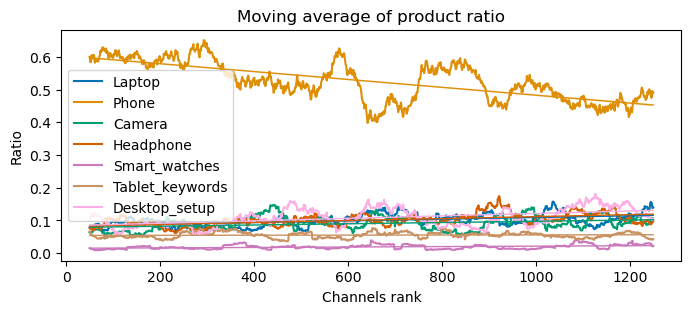

In [47]:
# define a new rank to the channels depending on its number of subscribers
df_tech_review_channels['new_rank'] = pd.Series(range(1, df_tech_review_channels.shape[0]+1))

# flag the channels with wide/narrow range of tech products to be used later
tech_df_prd_perc.loc[tech_df_prd_perc.apply(lambda df: any(df[p] > 0.8 for p in products), axis=1),'wide_range'] = False
tech_df_prd_perc['wide_range'].fillna(True, inplace=True)

# merge
channels_rank = pd.merge(df_tech_review_channels[['subscribers_cc','channel_id','new_rank']],tech_df_prd_perc,on='channel_id',how='right').sort_values(by='new_rank',ascending=True).reset_index(drop=True)

# moving average of category percentage per rank
colors = sns.color_palette("colorblind",len(products))
plt.figure(figsize=(8,3))

# plot moving average
for idx,product in enumerate(products):
    ax = sns.lineplot(x=channels_rank['new_rank'], y=channels_rank[product].rolling(50).mean(), label=product.capitalize(),color=colors[idx])

# Add regression lines
for idx,product in enumerate(products):
    sns.regplot(x=channels_rank['new_rank'], y=channels_rank[product].rolling(50).mean(), scatter=False, ax=ax, color=colors[idx], line_kws={'linewidth': 1})

ax.set(title='Moving average of product ratio', xlabel='Channels rank', ylabel='Ratio')
plt.legend()
plt.show()


In [55]:
# define average upload frequency per channel
tech_mt_uf = df_tech_review_mt.copy()
tech_mt_uf['upload_date'] = pd.to_datetime(tech_mt_uf.upload_date)
tech_mt_uf.sort_values(by=['channel_id','upload_date'],ascending=True,inplace=True)
tech_mt_uf['delay'] = tech_mt_uf.upload_date - tech_mt_uf.shift(1).upload_date
# set all first uploads to 0
first_upload = tech_mt_uf.groupby('channel_id',as_index=False)[['upload_date']].min()
first_upload['is_first'] = True
tech_df_upload_freq = pd.merge(tech_mt_uf,first_upload,on=['channel_id','upload_date'],how='left')
tech_df_upload_freq.is_first.fillna(False,inplace=True)
tech_df_upload_freq.loc[tech_df_upload_freq.is_first,'delay'] = pd.Timedelta(seconds=0)
tech_df_upload_freq['upload_year'] = tech_df_upload_freq.upload_date.dt.year
tech_df_upload_freq['upload_month'] = tech_df_upload_freq.upload_date.dt.month
tech_df_avg = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['delay']].mean().groupby(['channel_id','upload_year'],as_index=False)[['delay']].mean().groupby(['channel_id'],as_index=False)[['delay']].mean()
tech_df_avg.rename({'delay':'avg_delay'},axis=1,inplace=True)
tech_df_avg.avg_delay = (tech_df_avg.avg_delay / np.timedelta64(1, 'D')).astype(float)

# define average duration
tech_df_avg_dur = tech_df_upload_freq.groupby(['channel_id','upload_year','upload_month'],as_index=False)[['duration']].mean().groupby(['channel_id','upload_year'],as_index=False)[['duration']].mean().groupby(['channel_id'],as_index=False)[['duration']].mean()
tech_df_avg_dur.rename({'duration':'avg_duration'},axis=1,inplace=True)

# define dataframe for observational study
df_obs = pd.merge(df_tech_review_channels[['channel_id','subscribers_cc']],tech_df_avg_dur,on='channel_id',how='left')
df_obs = pd.merge(df_obs,tech_df_avg,on='channel_id',how='left')
df_obs = pd.merge(df_obs,channels_rank[['channel_id','wide_range','new_rank']],on='channel_id',how='right')
df_obs.loc[df_obs['wide_range'],'wide_range'] = 1
df_obs.loc[df_obs['wide_range'] != 1,'wide_range'] = 0
df_obs['wide_range'] = df_obs['wide_range'].astype(int)
print("# of 'wide' channels: {}".format(df_obs.wide_range.sum()))
print("# of 'narrow' channels: {}".format(df_obs.wide_range.count() - df_obs.wide_range.sum()))
display(df_obs.sample(5))

# of 'wide' channels: 958
# of 'narrow' channels: 290


,channel_id,subscribers_cc,avg_duration,avg_delay,wide_range,new_rank
253,UCp8XkNZn-UOPELh9ynq1t9g,235000,348.253788,32.455833,0,255
798,UCvuMB6dXNYL-Z9cAKsumVWw,33800,264.522619,8.651157,1,801
1247,UCqcOdYkYBroLwnaKPWVdNRA,10100,1190.065096,5.608916,1,1250
1007,UC5B_HWlmUBJ8p9tUfGquYQw,19300,211.162239,16.037765,1,1010
1053,UChWHCJy_4sjmLgs04DHS6og,17700,896.732639,10.815972,0,1056


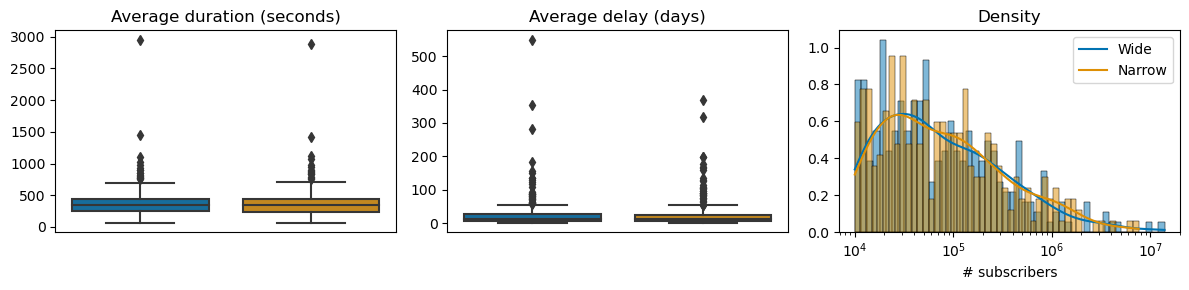

In [61]:
# balance the treat and control groups
match_idx = balance_data(df=df_obs,treat_column='wide_range',continuous_features=['avg_duration','avg_delay'])
df_obs_matched = df_obs.iloc[match_idx]

# plot
colors = sns.color_palette("colorblind",2)
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,3))

sns.boxplot(y=df_obs_matched['avg_duration'],x=df_obs_matched['wide_range'],ax=axes[0],palette=colors)
sns.boxplot(y=df_obs_matched['avg_delay'],x=df_obs_matched['wide_range'],ax=axes[1],palette=colors)
sns.histplot(df_obs_matched[df_obs_matched['wide_range'] == 1]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[2],color=colors[0])
sns.histplot(df_obs_matched[df_obs_matched['wide_range'] == 0]['subscribers_cc'],stat='density',kde=True,bins=50,log_scale=(True,False),ax=axes[2],color=colors[1])

axes[0].set(title='Average duration (seconds)',xlabel=None,ylabel=None,xticks=[])
axes[1].set(title='Average delay (days)',xlabel=None,ylabel=None,xticks=[])
axes[2].set(title='Density',xlabel='# subscribers',ylabel=None)
axes[2].legend(['Wide','Narrow'])

plt.tight_layout()
plt.show()

From the above distribution of 'narrow' and 'wide' channels, we can see non of the 2 groups is clearly outperforming the other. To see it more clearly we can also check the statistical difference between the 2 groups:

In [68]:
wide = df_obs_matched[df_obs_matched['wide_range']==1]
narrow = df_obs_matched[df_obs_matched['wide_range']==0]

# statistical difference between the number of subscribers of the 2 groups
print(ttest_ind(narrow['subscribers_cc'],wide['subscribers_cc']))

Ttest_indResult(statistic=-0.4449572010193068, pvalue=0.6565172625225137)


Because the pvalue > 0.05, we cannot reject the null hypothesis that is the mean number of subscribers of the "narrow" and "wide" channels are the same, meaning whether or not a channels focuses on a single product review, or covers a wider range of products, it does not have a direct influence on the growth of the channel, i.e. number of subscribers.

# To do (bipartite graph)
- U -> product types
- V -> channels
- get the projection U
    - size of the nodes means how popular the product type is.
    - we can also see what product types go together
    - (get centrality as well, if it helps)